In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline
from typing import Union,TypeVar
from datetime import datetime
import joblib
import sys
import json

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm

from TRGAN.TRGAN_main_V2 import *
from TRGAN.encoders import *
import TRGAN.TRGAN_train_load_modules as trgan
from TRGAN.evaluation_metrics import *
from TRGAN.methods_comparison import *
from TRGAN.TRGAN_light_preprocessing import *
from TRGAN.data_preprocessing import load_data

# import random

# random.seed(55555)
# np.random.seed(55555)


import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [203]:
# data = load_data(path='Data/', name='czech')
# data = load_data(path='Data/', name='users_spb_only')
# data = load_data(path='Data/', name='transaction_secret')
data = load_data(path='Data/', name='data_uk_clean')

In [3]:
data.head()

,account_id,amount,balance,description,date,id,type,tcode
0,835e3f4c1ea0f2ed,-32.00,306.00,BT Broadband,2017-04-01,f8aa72e2bf06862b,Debit,BT Broadband__Utility Bill__Debit
1,41631602b2500444,-7.99,740.01,Amazon Prime,2017-04-01,7dc5fe8e578fdc86,Debit,Amazon Prime__Subscription__Debit
2,4691da9d47227a68,-973.00,-42.00,Mortgage,2017-04-01,1dffd9ccf6e22cd7,Debit,Mortgage__Utility Bill__Debit
3,dd78a9b5418d8782,-968.00,-72.00,Mortgage,2017-04-01,98fcfaafab9774f7,Debit,Mortgage__Utility Bill__Debit
4,29610573ca5d43c1,-21.00,493.00,Three Mobile,2017-04-01,cf5f275d6d0b780e,Debit,Three Mobile__Utility Bill__Debit


In [56]:
onehot_cols = ['type', 'tcode']
cat_feat_names = ['account_id', 'description', 'id']
num_feat_names = ['amount', 'balance']
log1p_transform_cols = []
date_feature = 'date'
time_feature = ''
client_id = 'account_id'
mcc_name = 'tcode'

latent_dim = {'onehot': 20, 'categorical': 6, 'numerical': 6, 'cv': 20}

In [57]:
# onehot_cols = ['MCC', 'OpType', 'NAME', 'PaymentSystem', 'ISOWNTERMINAL']
# cat_feat_names = ['CustomerKey', 'ID', 'TERMINAL_CODE', 'ADDRESS',\
#                 'TRANS_DETAIL', 'DETAILED_CARD_TYPE', 'ACCOUNT_ID', 'CARD']

# num_feat_names = ['AMOUNT_EQ', 'PAY_AMT', 'HOUR', 'MINUTE', 'SECOND']
# log1p_transform_cols = ['AMOUNT_EQ', 'PAY_AMT']
# date_feature = 'DATE'
# time_feature = 'TRANS_TIME'
# client_id = 'CustomerKey'
# mcc_name = 'MCC'

# latent_dim = {'onehot': 30, 'categorical': 4, 'numerical': 3, 'cv': 20}

In [58]:
# onehot_cols = ['shop']
# cat_feat_names = ['TRANS_DETAIL', 'customer']

# num_feat_names = ['AMOUNT_EQ', 'HOUR', 'MINUTE', 'SECOND']
# log1p_transform_cols = ['AMOUNT_EQ']
# date_feature = 'TRANS_DATE'
# time_feature = 'TRANS_TIME'
# client_id = 'customer'
# mcc_name = 'shop'

# latent_dim = {'onehot': 30, 'categorical': len(cat_feat_names), 'numerical': len(num_feat_names), 'cv': 20}

In [59]:
# cat_feat_names = ['customer']
# onehot_cols = ['mcc']
# num_feat_names = ['amount', 'balance', 'age']
# log1p_transform_cols = ['amount']
# date_feature = 'transaction_date'
# time_feature = ''
# client_id = 'customer'
# mcc_name = 'mcc'

# latent_dim = {'onehot': 20, 'categorical': 2, 'numerical': 2, 'cv': 10}

In [5]:
# normal, sc = prob_int_transform(X_emb[:, latent_dim['onehot']:-latent_dim['numerical']])
# s = synth_data[:, latent_dim['onehot']:-latent_dim['numerical']]
# s = (s - np.mean(s, axis=0)) / np.std(s, axis=0)

# plt.hist(X_emb[:, latent_dim['onehot']:-latent_dim['numerical']][:, 0], bins=60, alpha=0.7)
# plt.hist(s[:, 0], bins=60, alpha=0.7)

# plt.show()

# plt.hist(inverse_prob_int_transform(s, scaler_cat['scaler_01'])[:, 6], bins=60)
# plt.show()

In [6]:
# data = log1p_transform(data, log1p_transform_cols)

In [60]:
%%time

X_emb, X_oh, cond_vector, synth_date, scaler_cat, scaler_onehot, scaler_num, cv_params, scaler, round_array = \
            trgan.embeddings(data, cat_feat_names, num_feat_names, onehot_cols, date_feature, time_feature, client_id, latent_dim, device=DEVICE, load=False, epochs=40)

Loss E_num: 1.0013224738258941e-07: 100%|██████████| 40/40 [00:25<00:00,  1.59it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000094181: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


CPU times: user 6min 46s, sys: 31.2 s, total: 7min 17s
Wall time: 2min 56s


In [61]:
%%time

dim_noise = 20
generator, supervisor, loss_array = trgan.train(X_emb, cond_vector, latent_dim, dim_noise, epochs=40, load=False)

Discriminator Loss: -0.04997 || Discriminator 2 Loss: -0.00141 || Generator Loss: 0.04003 || Supervisor Loss: 0.02948: 100%|██████████| 40/40 [01:13<00:00,  1.84s/it]

CPU times: user 4min 12s, sys: 28.5 s, total: 4min 40s
Wall time: 1min 13s


In [200]:
n_samples = len(X_emb[:])
synth_data, synth_date, params = sample(n_samples, generator, supervisor, dim_noise, cond_vector, X_emb, cv_params['encoder'], data,\
                                date_feature, client_id, cv_params=cv_params, device=DEVICE)

X_emb1 = scaler.inverse_transform(X_emb)
synth_data = scaler.inverse_transform(synth_data)

synth_df = inverse_transform(synth_data, latent_dim, X_oh.columns, scaler_onehot, scaler_cat, scaler_num, cat_feat_names,
                             mcc_name, num_feat_names, True, synth_date, time_feature, round_array)

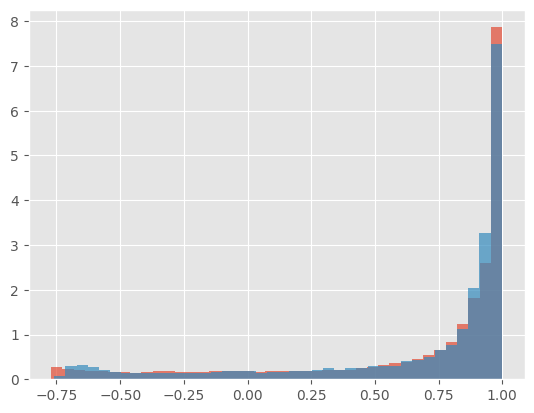

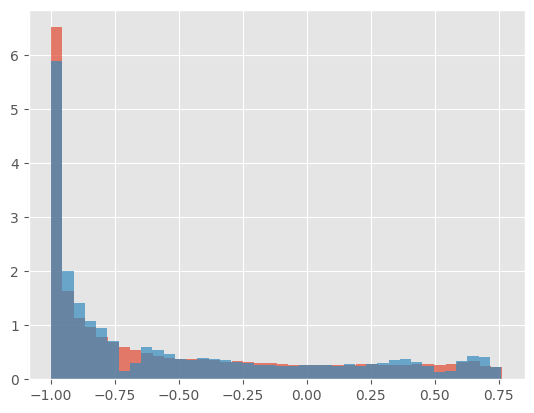

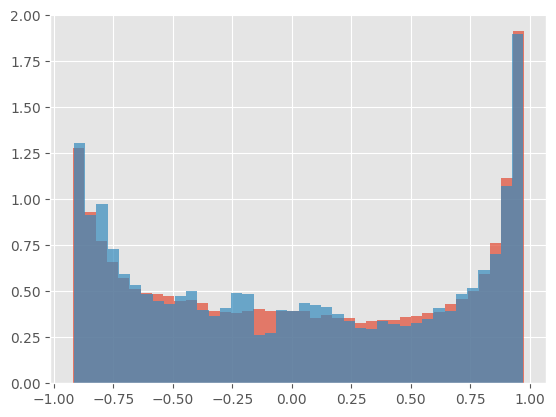

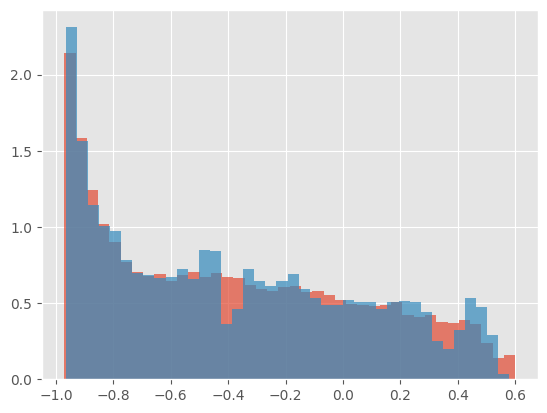

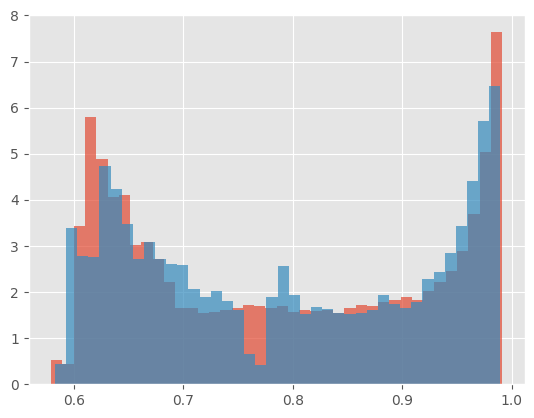

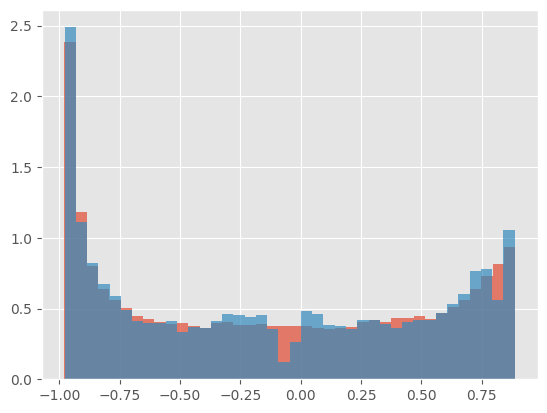

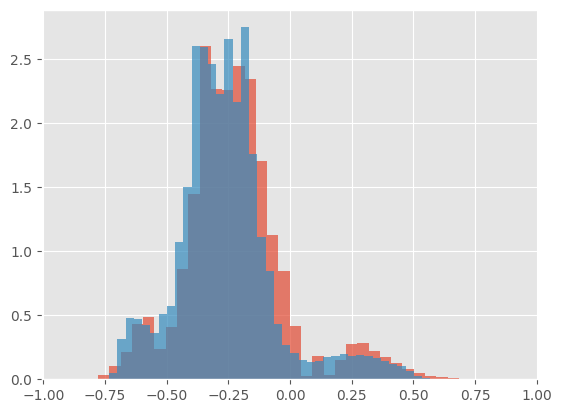

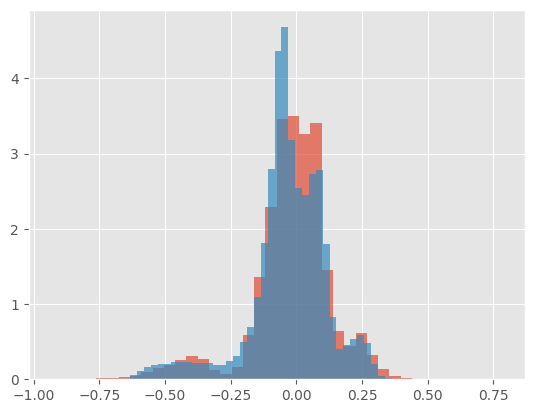

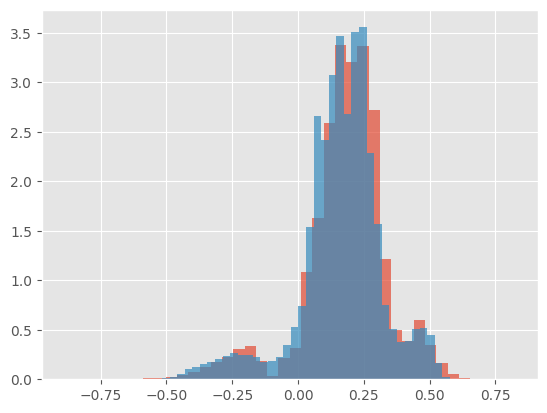

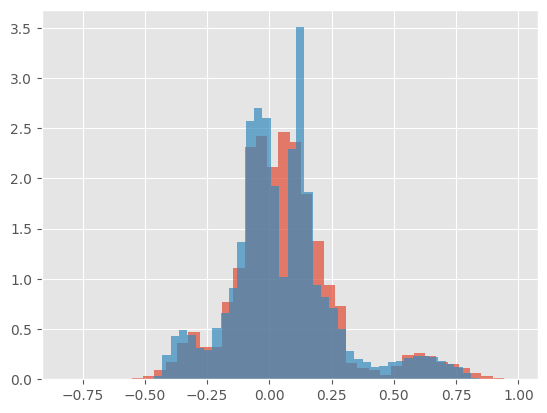

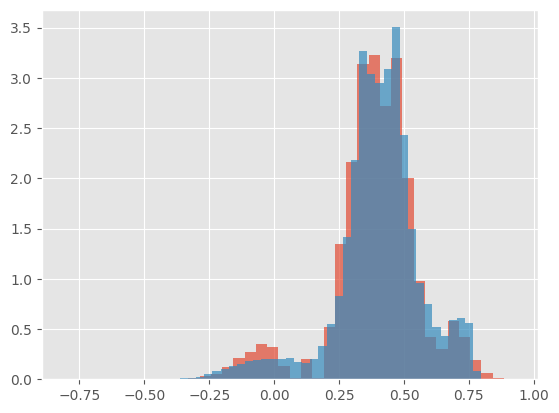

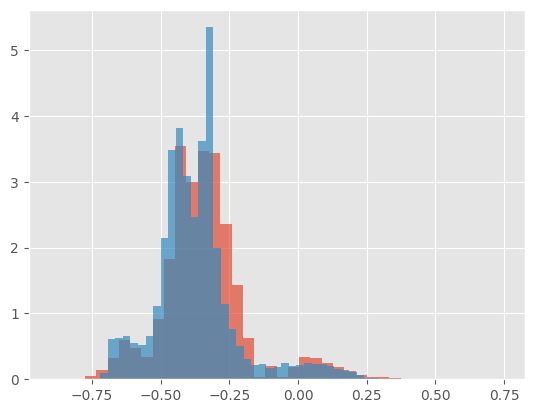

In [63]:
# for i in range(latent_dim['onehot'],X_emb1.shape[1]):
#     plt.hist(X_emb1[:, i], bins=40, alpha=0.7, density=True)
#     plt.hist(synth_data[:, i], bins=40, alpha=0.7, density=True)

#     plt.show()

In [64]:
synth_df.head()

,type,tcode,account_id,description,id,amount,balance,date
0,Debit,BT Broadband__Utility Bill__Debit,7750e23a2a77dead,BT Broadband,f529c0026ef313cf,-1589.41,-2970.29,2017-04-01
1,Debit,Amazon Prime__Subscription__Debit,b9e88d39e08f846d,BT Broadband,890f84c05665a26c,-1574.31,-2907.59,2017-04-01
2,Debit,Credit Card Payment__Credit Card__Debit,b9e88d39e08f846d,BT Broadband,0a4d1b933072b87f,-1564.84,-2866.56,2017-04-01
3,Debit,Mortgage__Utility Bill__Debit,b9e88d39e08f846d,BT Broadband,4cb2ea4a82616c3f,-1559.18,-2841.83,2017-04-01
4,Debit,Three Mobile__Utility Bill__Debit,b9e88d39e08f846d,BT Broadband,19fcd8d6232fded8,-1555.91,-2828.58,2017-04-01


## Evaluation

In [65]:
# X_emb2 = copy.deepcopy(X_emb1)
# temp = copy.deepcopy(X_emb1[:, -3:])
# np.random.shuffle(temp)
# X_emb2[:, -3:] = temp

# synth_df = inverse_transform(X_emb1 + np.random.normal(0, 0.001,size=X_emb1.shape), latent_dim, X_oh.columns, scaler_onehot, scaler_cat, scaler_num, cat_feat_names,
#                              mcc_name, num_feat_names, True, synth_date, time_feature, round_array)

In [71]:
cat_feat_names

['account_id', 'description', 'id']

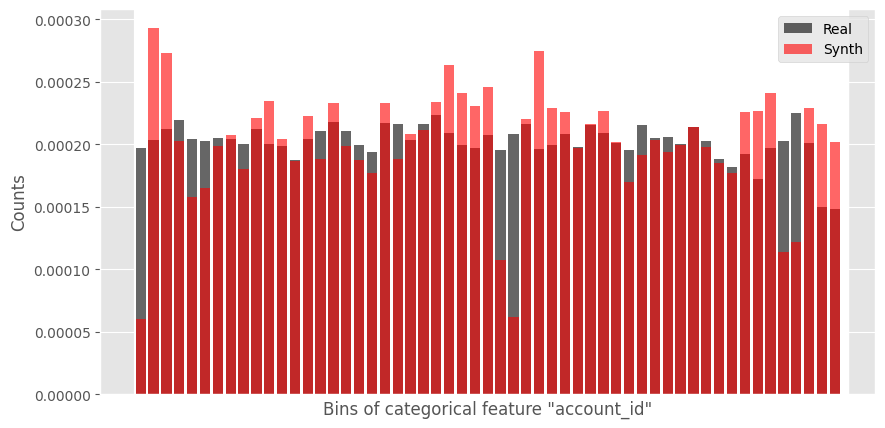

In [171]:
plot_hist_categorical(data, synth_df, 'account_id', 90)

In [73]:
# data = inverse_log1p_transform(data, log1p_transform_cols)
# synth_df = inverse_log1p_transform(synth_df, log1p_transform_cols)

In [74]:
num_feat_names

['amount', 'balance']

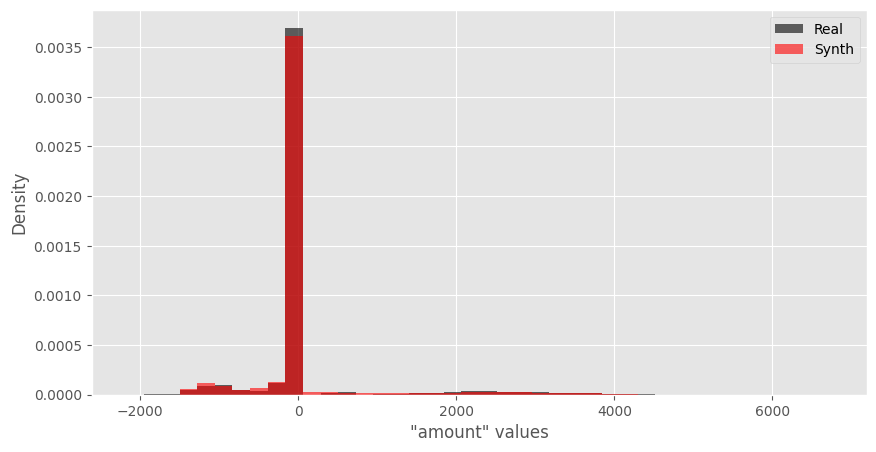

In [165]:
plot_hist_numerical(data, synth_df, 'amount', tick=40)

In [166]:
evaluate_numerical([data['amount'], synth_df['amount']], ['Real', 'TRGAN'])

,Mean,Std,Kurtosis,Skewness,D_JS,Wassertein distance
Real,72.8,765.0,11.2,3.0,0.0000,0.00
TRGAN,38.2,717.0,12.1,3.0,0.0837,39.16


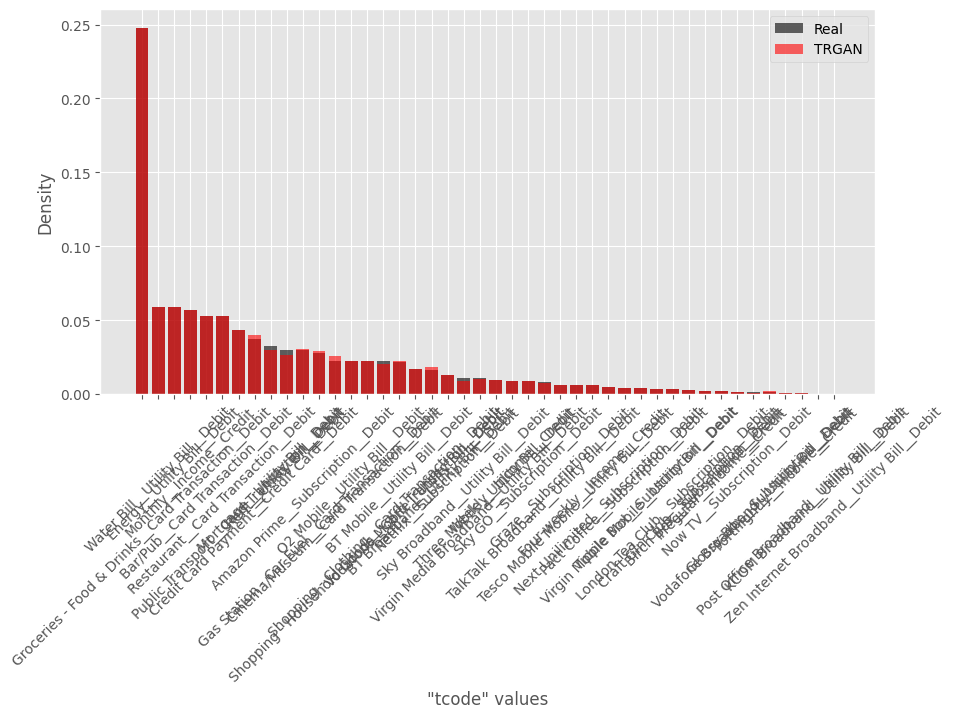

In [78]:
plot_hist_onehot(data, synth_df, mcc_name)

In [221]:
def evaluate_categorical(data_array, index, data_cont_array, mcc_name):
    data_array = copy.deepcopy(data_array)
    
    if data_array[0][mcc_name].dtype == 'int' or data_array[0][mcc_name].dtype == 'float':
        tv_values = list(map(lambda x: TVComplement.compute(real_data=data_array[0][mcc_name], synthetic_data=x[mcc_name]), data_array))
    
        cont_sim_value = list(map(lambda x: ContingencySimilarity.compute(real_data=data_array[0][data_cont_array], synthetic_data=x[data_cont_array]), data_array))
        val_counts = list(map(lambda x: int(x[mcc_name].value_counts().shape[0]), data_array))

        js_divergence = list(map(lambda x: jensenshannon(data_array[0][mcc_name], x[mcc_name]), data_array))

        res_df = pd.DataFrame(np.array([tv_values, cont_sim_value, val_counts, js_divergence]).T,\
                            columns=['Total Variation', 'Contingency Similarity', 'Values count', 'D_JS'], index=index)
        
    elif data_array[0][mcc_name].dtype == 'object':
        le = LabelEncoder()
        le2 = LabelEncoder()
        data_array_le = []
        
        for df in data_array:
            df[data_cont_array[0]] = le.fit_transform(df[data_cont_array[0]])
            df[data_cont_array[1]] = le2.fit_transform(df[data_cont_array[1]])
            data_array_le.append(df)
        
        tv_values = list(map(lambda x: TVComplement.compute(real_data=data_array_le[0][mcc_name], synthetic_data=x[mcc_name]), data_array_le))
        cont_sim_value = list(map(lambda x: ContingencySimilarity.compute(real_data=data_array_le[0][data_cont_array], synthetic_data=x[data_cont_array]), data_array_le))
        val_counts = list(map(lambda x: int(x[mcc_name].value_counts().shape[0]), data_array_le))

        js_divergence = list(map(lambda x: jensenshannon(data_array_le[0][mcc_name], x[mcc_name]), data_array_le))

        res_df = pd.DataFrame(np.array([tv_values, cont_sim_value, val_counts, js_divergence]).T,\
                            columns=['Total Variation', 'Contingency Similarity', 'Values count', 'D_JS'], index=index)

    return res_df

In [224]:
evaluate_categorical([data, synth_df], ['Real', 'TRGAN'], ['date', mcc_name], mcc_name)

,Total Variation,Contingency Similarity,Values count,D_JS
Real,1.0000,1.000000,44.0,0.000000
TRGAN,0.9886,0.563131,44.0,0.054069


In [79]:
data[mcc_name].value_counts()

tcode
Groceries - Food & Drinks__Card Transaction__Debit     24779
Water Bill__Utility Bill__Debit                         5933
Energy__Utility Bill__Debit                             5917
Monthly__Income__Credit                                 5717
Bar/Pub__Card Transaction__Debit                        5316
Restaurant__Card Transaction__Debit                     5281
Public Transport__Card Transaction__Debit               4326
Credit Card Payment__Credit Card__Debit                 3733
Mortgage__Utility Bill__Debit                           3262
Rent__Utility Bill__Debit                               2970
Amazon Prime__Subscription__Debit                       2960
Gas Station - Car Fuel__Card Transaction__Debit         2771
Cinema/Museum__Card Transaction__Debit                  2275
O2 Mobile__Utility Bill__Debit                          2248
Shopping - Household Goods__Card Transaction__Debit     2241
Shopping - Clothing__Card Transaction__Debit            2234
BT Mobile__Utility

In [80]:
synth_df[mcc_name].value_counts()

tcode
Groceries - Food & Drinks__Card Transaction__Debit     24791
Energy__Utility Bill__Debit                             5921
Water Bill__Utility Bill__Debit                         5893
Monthly__Income__Credit                                 5723
Bar/Pub__Card Transaction__Debit                        5316
Restaurant__Card Transaction__Debit                     5279
Public Transport__Card Transaction__Debit               4353
Credit Card Payment__Credit Card__Debit                 4002
Amazon Prime__Subscription__Debit                       3065
Mortgage__Utility Bill__Debit                           2999
Gas Station - Car Fuel__Card Transaction__Debit         2943
Rent__Utility Bill__Debit                               2662
Cinema/Museum__Card Transaction__Debit                  2553
O2 Mobile__Utility Bill__Debit                          2248
Shopping - Household Goods__Card Transaction__Debit     2242
BT Mobile__Utility Bill__Debit                          2215
Shopping - Clothin

In [127]:
def evaluate(num_exp = 31):
    epochs = tqdm(range(num_exp))
    stats = []
    
    for _ in epochs:
        X_emb, X_oh, cond_vector, synth_date, scaler_cat, scaler_onehot, scaler_num, cv_params, scaler, round_array = \
                trgan.embeddings(data, cat_feat_names, num_feat_names, onehot_cols, date_feature, time_feature, client_id, latent_dim, device=DEVICE, load=False, epochs=40)

        dim_noise = 20
        generator, supervisor, loss_array = trgan.train(X_emb, cond_vector, latent_dim, dim_noise, epochs=30, load=False)

        synth_data_arr = []
        for _ in range(num_exp):
            n_samples = len(X_emb[:])
            synth_data, synth_date, params = sample(n_samples, generator, supervisor, dim_noise, cond_vector, X_emb, cv_params['encoder'], data,\
                                                    date_feature, client_id, cv_params=cv_params, device=DEVICE)
            
            synth_data_arr.append(synth_data)
    
        synth_data = np.sum(synth_data_arr, axis=0)/num_exp
        synth_data = scaler.inverse_transform(synth_data)
        synth_df = inverse_transform(synth_data, latent_dim, X_oh.columns, scaler_onehot, scaler_cat, scaler_num, cat_feat_names,
                                mcc_name, num_feat_names, True, synth_date, time_feature, round_array)
            
        stats.append(evaluate_numerical([data['amount'], synth_df['amount']], ['Real', 'TRGAN']))
        
    return stats

In [128]:
stats = evaluate(2)

Loss E_num: 2.0099056996514264e-07: 100%|██████████| 40/40 [00:24<00:00,  1.66it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000070653: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]
Discriminator Loss: -0.04917 || Discriminator 2 Loss: -0.00115 || Generator Loss: 0.02946 || Supervisor Loss: -0.00508: 100%|██████████| 30/30 [00:48<00:00,  1.60s/it]
Loss E_num: 2.1596126487111178e-07: 100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000233736: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]
Discriminator Loss: -0.04928 || Discriminator 2 Loss: -0.00296 || Generator Loss: 0.01404 || Supervisor Loss: 0.03523: 100%|██████████| 30/30 [00:48<00:00,  1.61s/it]
100%|██████████| 2/2 [07:35<00:00, 227.54s/it]


In [163]:
statistics = {'mean': [], 'std': [], 'kurt': [], 'skew': [], 'js': [], 'wd': []}

for df in stats:
    statistics['mean'].append(df['Mean']['TRGAN'])
    statistics['std'].append(df['Std']['TRGAN'])
    statistics['kurt'].append(df['Kurtosis']['TRGAN'])
    statistics['skew'].append(df['Skewness']['TRGAN'])
    statistics['js'].append(df['D_JS']['TRGAN'])
    statistics['wd'].append(df['Wassertein distance']['TRGAN'])

z_critical = sts.norm.ppf(q = 1 - 0.05/2)

pd.DataFrame([
    [f'{round(np.mean(statistics["mean"]), 1)} +- {round(np.std(statistics["mean"], ddof=1), 1)}'
     f' (+- {np.around(z_critical * (np.std(statistics["mean"],ddof=1) / np.sqrt(len(statistics["mean"]))), 1)})',
     
    f'{round(np.mean(statistics["std"]), 1)} +- {round(np.std(statistics["std"], ddof=1), 1)}'
    f' (+- {np.around(z_critical * (np.std(statistics["std"],ddof=1) / np.sqrt(len(statistics["std"]))), 1)})',
    
    f'{round(np.mean(statistics["kurt"]), 1)} +- {round(np.std(statistics["kurt"], ddof=1), 1)}'
    f' (+- {np.around(z_critical * (np.std(statistics["kurt"],ddof=1) / np.sqrt(len(statistics["kurt"]))), 1)})',
    
    f'{round(np.mean(statistics["skew"]), 1)} +- {round(np.std(statistics["skew"], ddof=1), 1)}'
    f' (+- {np.around(z_critical * (np.std(statistics["skew"],ddof=1) / np.sqrt(len(statistics["skew"]))), 1)})',
    
    f'{round(np.mean(statistics["js"]), 1)} +- {round(np.std(statistics["js"], ddof=1), 1)}'
    f' (+- {np.around(z_critical * (np.std(statistics["js"],ddof=1) / np.sqrt(len(statistics["js"]))), 1)})',
    
    f'{round(np.mean(statistics["wd"]), 1)} +- {round(np.std(statistics["wd"], ddof=1), 1)}'
    f' (+- {np.around(z_critical * (np.std(statistics["wd"],ddof=1) / np.sqrt(len(statistics["wd"]))), 1)})'],
              ], index=['TRGAN'], columns=['MEAN', 'STD', 'KURTOSIS', 'SKEWNESS', 'D_JS', 'WD'])

,MEAN,STD,KURTOSIS,SKEWNESS,D_JS,WD
TRGAN,72.1 +- 23.5 (+- 32.5),761.6 +- 42.4 (+- 58.7),11.8 +- 0.2 (+- 0.3),3.0 +- 0.0 (+- 0.0),0.1 +- 0.0 (+- 0.0),40.0 +- 2.5 (+- 3.5)


In [97]:
synth_df['amount']

0       -1589.41
1       -1574.31
2       -1564.84
3       -1559.18
4       -1555.91
          ...   
99993    4722.87
99994    4790.41
99995    4857.92
99996    4887.15
99997    4999.87
Name: amount, Length: 99998, dtype: float64

In [96]:
synth_df['amount'].iloc[scaler_num['index_df_sort'][:, 0]]

26149     -53.27
92297     183.49
21599     -59.42
92557     268.92
12912    -121.23
          ...   
47891     -40.61
47622     -40.89
29082     -50.26
94248    1181.53
34736     -46.76
Name: amount, Length: 99998, dtype: float64

In [94]:
scaler_num['index_df_sort']

array([[26149, 96827],
       [92297, 96176],
       [21599, 92947],
       ...,
       [29082, 76222],
       [94248, 89500],
       [34736, 74645]])

In [86]:
# contig_cols = ['account_id', mcc_name]

# evaluate_categorical([data[mcc_name], synth_df[mcc_name]],\
#         index=['Real', 'TRGAN'],\
#         data_cont_array=[data[contig_cols], synth_df[contig_cols]])

In [41]:
onehot_cols

['type', 'tcode']

In [42]:
data['type'].value_counts()

type
Debit     92429
Credit     7569
Name: count, dtype: int64

In [43]:

synth_df['type'].value_counts()

type
Debit     92429
Credit     7569
Name: count, dtype: int64

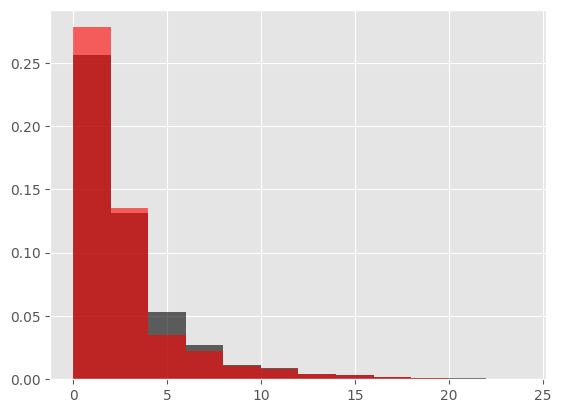

In [44]:
plt.hist(np.hstack(cv_params['deltas_real']), alpha=0.6, bins=np.arange(-1, 25, 2) + 1, label='Real', density=True, color='black')
plt.hist(np.hstack(cv_params['deltas_synth']), alpha=0.6, bins=np.arange(-1, 25, 2) + 1, label='Real', density=True, color='red')
plt.show()

In [228]:
# plt.hist(data[time_feature].dt.hour.values, alpha=0.6, bins=np.arange(-1, 24, 1) + 1, label='Real', density=True, color='black')
# plt.hist(pd.to_datetime(synth_df[time_feature]).dt.hour.values, alpha=0.6, bins=np.arange(-1, 24, 1) + 1, label='Real', density=True, color='red')
# plt.show()

In [229]:
# plt.hist(data[time_feature].dt.minute.values, alpha=0.6, bins=np.arange(-1, 60, 1) + 1, label='Real', density=True, color='black')
# plt.hist(pd.to_datetime(synth_df[time_feature]).dt.minute.values, alpha=0.6, bins=np.arange(-1, 60, 1) + 1, label='Real', density=True, color='red')
# plt.show()

In [230]:
# plt.hist(data[time_feature].dt.second.values, alpha=0.6, bins=np.arange(-1, 60, 1) + 1, label='Real', density=True, color='black')
# plt.hist(pd.to_datetime(synth_df[time_feature]).dt.second.values, alpha=0.6, bins=np.arange(-1, 60, 1) + 1, label='Real', density=True, color='red')
# plt.show()

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)

pca_real = pca.fit_transform(X_emb1)
pca_synth = pca.transform(synth_data)

In [29]:
# pca = TSNE(n_components=2)
# pca_synth = pca.fit_transform(synth_data)

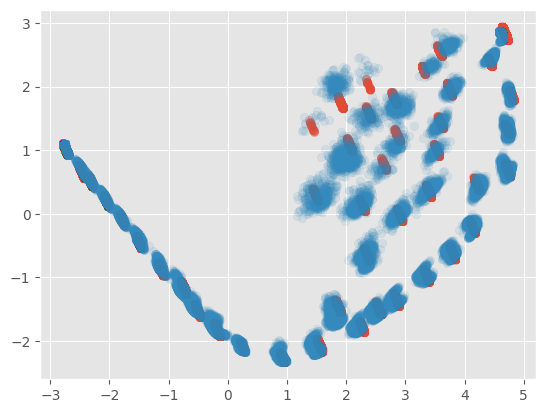

In [30]:
plt.scatter(pca_real[:, 0], pca_real[:, 1], alpha=0.3)
plt.scatter(pca_synth[:, 0], pca_synth[:, 1], alpha=0.1)

plt.show()